# Modélisation regression par département

In [1]:
from sklearn.decomposition import PCA
# ^^^ pyforest auto-imports - don't write above this line
import pandas as pd 
import numpy as np
#from sklearn import model_selection, preprocessing
#from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator,TransformerMixin
pd.set_option('display.max_columns', None)
from sklearn.linear_model import Lasso, lasso_path, LassoCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier, StackingRegressor
from sklearn.svm import SVR

Chargement base DVF, base concernant les salaires, et concernant la population

In [2]:
df = pd.read_csv("06 - dvf_with_equip_loyers_revenus_2020v2.csv")

#On garde la france metropolitaine
df = df[(df["Code departement"] != 971)&
        (df["Code departement"] != 972)&
        (df["Code departement"] != 973)&
        (df["Code departement"] != 974)]

#on intègre les salaires
salaire = pd.read_csv("salaire.csv",sep=";",decimal=",",dtype = {'Code departement': int})
salaire = salaire[['SNHMO18','SNHMFO18',"Code departement"]]
df = df.merge(salaire, on = "Code departement", how = 'left')
del salaire

#on intègre la population par commune
population = pd.read_csv("population.csv", sep =";", dtype = {'Population municipale': int,
                                                              'Population comptee a part':int,
                                                              'Population totale':int,
                                                              'Code commune INSEE':int})
population = population[["Population totale",'Code commune INSEE']]
df = df.merge(population, on = "Code commune INSEE", how = 'left')
del population

for i in df["Code departement"].unique():
    DISP_Q118_mean =  df.loc[ df["Code departement"] == i , ['DISP_Q118'] ].mean()
    DISP_MED18_mean = df.loc[ df["Code departement"] == i , ['DISP_MED18'] ].mean()
    DISP_Q318_mean = df.loc[ df["Code departement"] == i , ['DISP_Q318'] ].mean()
    DISP_GI18_mean = df.loc[ df["Code departement"] == i , ['DISP_GI18'] ].mean()
    df.loc[ df["Code departement"] == i , ['DISP_Q118'] ] = df.loc[ df["Code departement"] == i , ['DISP_Q118'] ].fillna(DISP_Q118_mean)
    df.loc[ df["Code departement"] == i , ['DISP_MED18'] ] = df.loc[ df["Code departement"] == i , ['DISP_MED18'] ].fillna(DISP_MED18_mean)
    df.loc[ df["Code departement"] == i , ['DISP_Q318'] ] = df.loc[ df["Code departement"] == i , ['DISP_Q318'] ].fillna(DISP_Q318_mean)
    df.loc[ df["Code departement"] == i , ['DISP_GI18'] ] = df.loc[ df["Code departement"] == i , ['DISP_GI18'] ].fillna(DISP_GI18_mean)
    
df = df.fillna(0) 

Gestion des valeurs manquantes : à voir si autre alternative pour DISP_MED??

Création des nouvelles features 

In [3]:
#Prix moyen par département
#prix_moyen_dept = pd.DataFrame(df.groupby(["dep_name"]).mean()["Valeur fonciere"]).rename({"Valeur fonciere":'Prix moyen par departement'},axis =1)
#df = df.merge(prix_moyen_dept, on = "dep_name", how = "left")
#del prix_moyen_dept

#Prix moyen m2 par département
#prix_m2_moyen_dept = pd.DataFrame(df.groupby(["dep_name"]).mean()["Prix m2"]).rename({"Prix m2":'Prix m2 moyen par departement'},axis =1)
#df = df.merge(prix_m2_moyen_dept, on = "dep_name", how = "left")
#del prix_m2_moyen_dept

#prix moyen par région
#prix_moyen_reg = pd.DataFrame(df.groupby(["region_name"]).mean()["Valeur fonciere"]).rename({"Valeur fonciere":'Prix moyen par region'},axis =1)
#df = df.merge(prix_moyen_reg, on = "region_name", how = "left")
#del prix_moyen_reg

#prix moyen m2 par région
#prix_m2_moyen_reg = pd.DataFrame(df.groupby(["region_name"]).mean()["Prix m2"]).rename({"Prix m2":'Prix m2 moyen par region'},axis =1)
#df = df.merge(prix_m2_moyen_reg, on = "region_name", how = "left")
#del prix_m2_moyen_reg

#prix moyen par commune
prix_moyen_commune = pd.DataFrame(df.groupby(["Commune"]).mean()["Valeur fonciere"]).rename({"Valeur fonciere":'Prix moyen par commune'},axis =1)
df = df.merge(prix_moyen_commune, on = "Commune", how = "left")
del prix_moyen_commune

#prix moyen par commune
prix_m2_moyen_commune = pd.DataFrame(df.groupby(["Commune"]).mean()["Prix m2"]).rename({"Prix m2":'Prix m2 moyen par commune'},axis =1)
df = df.merge(prix_m2_moyen_commune, on = "Commune", how = "left")
del prix_m2_moyen_commune

#loyer moyen
df["loyer_moyen"] = (df["loy_maison"]+ df["loy_appart"])/2


df["Nb equip total"] = df["Alimentation"] + df["Aéroport"] +df["Baignade"] +df["Banques"] +df["Boulangerie"] +df["Camping"] 
df["Nb equip total"] = df["Nb equip total"] + df["Cinéma"] +df["Collège ou lycée"] +df["Crèche"] +df["Ecole mat et primaire"] 
df["Nb equip total"] = df["Nb equip total"]+df["Ecole sup"] +df["Etab hospi"] +df["Gare"] +df["Gare nationale"] +df["Hotels"] 
df["Nb equip total"] = df["Nb equip total"]+df["Info touristique"] +df["Parcours sportif/santé"]  +df["Pharmacie"]   
df["Nb equip total"] = df["Nb equip total"]+df["Police ou gendarmerie"]+df["Port plaisance"]+df["Restaurants"]+df["Resto U"] 
df["Nb equip total"] = df["Nb equip total"]+df["Résidence U"] +  df["Salle multisport"]

df.drop(['Unnamed: 0', 'Date mutation','Type de voie','Nombre de lots',
         'Code commune INSEE', 'Adresse', 'Code postal 5 chiffres',
         'code_iris_clean','dep_name','region_name','Commune',
         'année','mois','keepdep','Prix m2'], axis = 1, inplace = True)



In [4]:
objet = df[["Type local"]]
df.drop(["Type local"], axis = 1, inplace = True)
df = df.join(pd.get_dummies(objet))
del objet

In [5]:
df['Code departement'].nunique()

91

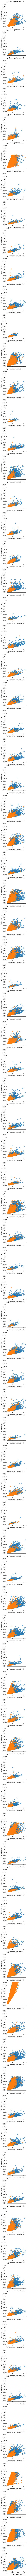

In [10]:
#g = sns.FacetGrid(df,row = "Code departement",hue="Type local_Appartement")
#g.map(plt.scatter, "Surface reelle bati", "Valeur fonciere", alpha = 0.7)

# Regression linéaire 

In [23]:
res_lr_final = pd.DataFrame(columns=['Actual','Predicted','Code departement'])

for i in df['Code departement'].unique():
    #On sélectionne le département
    data_departement = df[df["Code departement"]==i]
    target = data_departement["Valeur fonciere"]
    data = data_departement.drop(["Valeur fonciere","Code departement"],axis = 1)
    #On créé notre jeu de train/test
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=789)
    #On standardise
    #scaler=StandardScaler()
    #X_train=scaler.fit_transform(X_train)
    #X_test=scaler.transform(X_test)
    #On effectue un régression linéaire
    lr = LinearRegression()
    lr.fit(X_train,y_train)
    y_pred = lr.predict(X_test)
    #on stocke les résultats du département dans un data frame
    res_lr = pd.DataFrame(columns=['Actual','Predicted','Code departement'])
    res_lr["Actual"] = y_test
    res_lr["Predicted"] = y_pred
    res_lr['Code departement'] = i
    res_lr_final = res_lr_final.append(res_lr)
    #On affiche les scores
    print("RESULTATS pour le département : " , i)
    #print("Coefficient de détermination du modèle :", lr.score(X_train, y_train))
    print('Score de l ensemble de test', lr.score(X_test,y_test))
    #print("RMSE test : ", np.sqrt(mean_squared_error(y_test, y_pred)))
    print("MAE test : ", mean_absolute_error(y_test, y_pred))

print("RMSE test : ", np.sqrt(mean_squared_error(res_lr_final.Actual, res_lr_final.Predicted)))
print("MAE test : ", mean_absolute_error(res_lr_final.Actual, res_lr_final.Predicted))

RESULTATS pour le département :  75
Score de l ensemble de test 0.8964330424565498
MAE test :  80585.13632138858
RESULTATS pour le département :  1
Score de l ensemble de test 0.75331675794261
MAE test :  56447.97565723138
RESULTATS pour le département :  2
Score de l ensemble de test 0.6432267620740089
MAE test :  27539.359446960978
RESULTATS pour le département :  3
Score de l ensemble de test 0.5338994406049619
MAE test :  34839.91839364249
RESULTATS pour le département :  4
Score de l ensemble de test 0.6091026018703611
MAE test :  42660.15733662905
RESULTATS pour le département :  5
Score de l ensemble de test 0.707771289814356
MAE test :  35995.494666200306
RESULTATS pour le département :  6
Score de l ensemble de test 0.6307250732505703
MAE test :  62721.34940024525
RESULTATS pour le département :  7
Score de l ensemble de test 0.5875158319543281
MAE test :  40143.99326470674
RESULTATS pour le département :  8
Score de l ensemble de test 0.6221251898527738
MAE test :  24258.0857

Score de l ensemble de test 0.7280900080371128
MAE test :  73284.85560507204
RESULTATS pour le département :  79
Score de l ensemble de test 0.60476457279989
MAE test :  30184.853412200162
RESULTATS pour le département :  80
Score de l ensemble de test 0.6359474841699666
MAE test :  33020.8107920001
RESULTATS pour le département :  81
Score de l ensemble de test 0.5884317931648162
MAE test :  33368.66279873201
RESULTATS pour le département :  82
Score de l ensemble de test 0.6623313419012884
MAE test :  30465.20685720693
RESULTATS pour le département :  83
Score de l ensemble de test 0.6789752507084869
MAE test :  59788.63709522564
RESULTATS pour le département :  84
Score de l ensemble de test 0.671222857649789
MAE test :  43765.99283747304
RESULTATS pour le département :  85
Score de l ensemble de test 0.605097585363072
MAE test :  43083.84667796627
RESULTATS pour le département :  86
Score de l ensemble de test 0.6667237508651755
MAE test :  28137.839955151012
RESULTATS pour le dépa

# Random Forest

In [24]:
res_rf_final = pd.DataFrame(columns=['Actual','Predicted','Code departement'])

for i in df['Code departement'].unique():
    data_departement = df[df["Code departement"]==i]
    target = data_departement["Valeur fonciere"]
    data = data_departement.drop(["Valeur fonciere","Code departement"],axis = 1)
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=789)
    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train)
    X_test=scaler.transform(X_test)
    regr = RandomForestRegressor(random_state=0,n_jobs=-1)
    regr.fit(X_train,y_train)
    y_pred = regr.predict(X_test)
    res_rf = pd.DataFrame(columns=['Actual','Predicted','Code departement'])
    res_rf["Actual"] = y_test
    res_rf["Predicted"] = y_pred
    res_rf['Code departement'] = i
    res_rf_final = res_rf_final.append(res_rf)
    print("RESULTATS pour le département : " , i)
    #print("Coefficient de détermination du modèle :", lr.score(X_train, y_train))
    print('Score de l ensemble de test', regr.score(X_test,y_test))
    #print("RMSE test : ", np.sqrt(mean_squared_error(y_test, y_pred)))
    print("MAE test : ", mean_absolute_error(y_test, y_pred))
    
print("RMSE FINAL RF test : ", np.sqrt(mean_squared_error(res_rf_final.Actual, res_rf_final.Predicted)))
print("MAE FINAL RF test : ", mean_absolute_error(res_rf_final.Actual, res_rf_final.Predicted))

RESULTATS pour le département :  75
Score de l ensemble de test 0.9062415854809197
MAE test :  76667.87253008537
RESULTATS pour le département :  1
Score de l ensemble de test 0.8157538563578379
MAE test :  43870.72529596153
RESULTATS pour le département :  2
Score de l ensemble de test 0.5198361711427034
MAE test :  29982.984953051644
RESULTATS pour le département :  3
Score de l ensemble de test 0.5365905232413062
MAE test :  32567.062470748297
RESULTATS pour le département :  4
Score de l ensemble de test 0.6073846758503773
MAE test :  38314.74972723972
RESULTATS pour le département :  5
Score de l ensemble de test 0.7177190769011158
MAE test :  32400.360840608195
RESULTATS pour le département :  6
Score de l ensemble de test 0.6856115626098009
MAE test :  55676.7602651601
RESULTATS pour le département :  7
Score de l ensemble de test 0.6056294652046244
MAE test :  39198.114671987234
RESULTATS pour le département :  8
Score de l ensemble de test 0.6809763853885055
MAE test :  21737.

RESULTATS pour le département :  78
Score de l ensemble de test 0.8358509935433616
MAE test :  51748.06191757866
RESULTATS pour le département :  79
Score de l ensemble de test 0.5812690281555543
MAE test :  27929.651870736205
RESULTATS pour le département :  80
Score de l ensemble de test 0.6822359137035752
MAE test :  30228.81737568512
RESULTATS pour le département :  81
Score de l ensemble de test 0.585303475091048
MAE test :  31775.18356725146
RESULTATS pour le département :  82
Score de l ensemble de test 0.6162473181881762
MAE test :  31621.9441968537
RESULTATS pour le département :  83
Score de l ensemble de test 0.7348517281790256
MAE test :  51564.276506527975
RESULTATS pour le département :  84
Score de l ensemble de test 0.6473476135968386
MAE test :  43199.6111159545
RESULTATS pour le département :  85
Score de l ensemble de test 0.6583128858372441
MAE test :  38859.424075793075
RESULTATS pour le département :  86
Score de l ensemble de test 0.6760079585301928
MAE test :  2

### Support Vector Regressor

In [32]:
res_svr_final = pd.DataFrame(columns=['Actual','Predicted','Code departement'])

for i in df['Code departement'].unique():
    
    data_departement = df[df["Code departement"]==i]
    target = data_departement["Valeur fonciere"]
    data = data_departement.drop(["Valeur fonciere","Code departement"],axis = 1)
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=789)
    
    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train)
    X_test=scaler.transform(X_test)
    
    reg_svr = SVR(kernel = 'rbf')
    reg_svr.fit(X_train, y_train)
    y_pred = reg_svr.predict(X_test)
    
    res_svr = pd.DataFrame(columns=['Actual','Predicted','Code departement'])
    res_svr["Actual"] = y_test
    res_svr["Predicted"] = y_pred
    res_svr['Code departement'] = i
    res_svr_final = res_svr_final.append(res_svr)
    print("RESULTATS pour le département : " , i)
    #print("Coefficient de détermination du modèle :", lr.score(X_train, y_train))
    print('Score de l ensemble de test', reg_svr.score(X_test,y_test))
    #print("RMSE test : ", np.sqrt(mean_squared_error(y_test, y_pred)))
    print("MAE test : ", mean_absolute_error(y_test, y_pred))
    
print("RMSE SVR FINAL : ", np.sqrt(mean_squared_error(res_svr_final.Actual, res_svr_final.Predicted)))
print("MAE SVR FINAL : ", mean_absolute_error(res_svr_final.Actual, res_svr_final.Predicted))


RESULTATS pour le département :  75
Score de l ensemble de test -0.08101350735701884
MAE test :  272986.3836014169
RESULTATS pour le département :  1
Score de l ensemble de test -0.07915176993639461
MAE test :  112031.856609424
RESULTATS pour le département :  2
Score de l ensemble de test -0.0009001329802009739
MAE test :  46998.36042842942
RESULTATS pour le département :  3
Score de l ensemble de test -0.058336264334373
MAE test :  50741.83958320565
RESULTATS pour le département :  4
Score de l ensemble de test -0.03058454722966575
MAE test :  78252.10859641148
RESULTATS pour le département :  5
Score de l ensemble de test -0.02895433186641405
MAE test :  69816.32972289
RESULTATS pour le département :  6
Score de l ensemble de test -0.06000273309984605
MAE test :  107202.48509011799
RESULTATS pour le département :  7
Score de l ensemble de test -0.02383395090253715
MAE test :  69418.76212759358
RESULTATS pour le département :  8
Score de l ensemble de test -0.0005796379329845447
MAE 

Score de l ensemble de test -0.0380396622335859
MAE test :  63627.717847464715
RESULTATS pour le département :  77
Score de l ensemble de test -0.019025036901727077
MAE test :  82220.05080067168
RESULTATS pour le département :  78
Score de l ensemble de test -0.08773159100584738
MAE test :  143558.44109470583
RESULTATS pour le département :  79
Score de l ensemble de test -0.03630587831568022
MAE test :  50100.227039925274
RESULTATS pour le département :  80
Score de l ensemble de test -0.0319539656259189
MAE test :  56461.15293140195
RESULTATS pour le département :  81
Score de l ensemble de test -0.008655394795654692
MAE test :  57610.897739290915
RESULTATS pour le département :  82
Score de l ensemble de test -0.012793265967195433
MAE test :  56334.055274860315
RESULTATS pour le département :  83
Score de l ensemble de test -0.09930167520265276
MAE test :  109385.8667339555
RESULTATS pour le département :  84
Score de l ensemble de test -0.02193903632876615
MAE test :  82218.1213834

# KNN

In [25]:
res_knn_final = pd.DataFrame(columns=['Actual','Predicted','Code departement'])

for i in df['Code departement'].unique():
    
    data_departement = df[df["Code departement"]==i]
    target = data_departement["Valeur fonciere"]
    data = data_departement.drop(["Valeur fonciere","Code departement"],axis = 1)
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=789)
    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train)
    X_test=scaler.transform(X_test)
    
    knn = KNeighborsRegressor()
    param_grid = {"n_neighbors": np.arange(1,10,2)}
    knn_gscv = GridSearchCV(knn, param_grid, cv=5)
    knn_gscv.fit(X_train, y_train)
    y_pred = knn_gscv.predict(X_test)
    
    res_knn = pd.DataFrame(columns=['Actual','Predicted','Code departement'])
    res_knn["Actual"] = y_test
    res_knn["Predicted"] = y_pred
    res_knn['Code departement'] = i
    res_knn_final = res_knn_final.append(res_knn)
    print("RESULTATS pour le département : " , i)
    #print("Coefficient de détermination du modèle :", lr.score(X_train, y_train))
    print('Score de l ensemble de test', knn_gscv.score(X_test,y_test))
    #print("RMSE test : ", np.sqrt(mean_squared_error(y_test, y_pred)))
    print("MAE test : ", mean_absolute_error(y_test, y_pred))
    
print("RMSE KNN FINAL : ", np.sqrt(mean_squared_error(res_knn_final.Actual, res_knn_final.Predicted)))
print("MAE KNN FINAL : ", mean_absolute_error(res_knn_final.Actual, res_knn_final.Predicted))


RESULTATS pour le département :  75
Score de l ensemble de test 0.8144782303625273
MAE test :  106996.67135591639
RESULTATS pour le département :  1
Score de l ensemble de test 0.7601399349002866
MAE test :  52823.58896998799
RESULTATS pour le département :  2
Score de l ensemble de test 0.377177257957387
MAE test :  34108.041971830986
RESULTATS pour le département :  3
Score de l ensemble de test 0.39927903560114686
MAE test :  38555.33238095238
RESULTATS pour le département :  4
Score de l ensemble de test 0.4787614915324524
MAE test :  48652.89081439395
RESULTATS pour le département :  5
Score de l ensemble de test 0.6423480364296944
MAE test :  39384.32772635815
RESULTATS pour le département :  6
Score de l ensemble de test 0.61184717005313
MAE test :  62273.56439170759
RESULTATS pour le département :  7
Score de l ensemble de test 0.4518505301548438
MAE test :  49041.949006384675
RESULTATS pour le département :  8
Score de l ensemble de test 0.51456311569955
MAE test :  27701.9365

RESULTATS pour le département :  78
Score de l ensemble de test 0.7649799539681823
MAE test :  62531.70738058232
RESULTATS pour le département :  79
Score de l ensemble de test 0.3777804858702182
MAE test :  36506.50642285714
RESULTATS pour le département :  80
Score de l ensemble de test 0.5559188879350596
MAE test :  35878.14668432203
RESULTATS pour le département :  81
Score de l ensemble de test 0.37252576827313866
MAE test :  38857.87047953216
RESULTATS pour le département :  82
Score de l ensemble de test 0.4544471514942906
MAE test :  38245.387608058605
RESULTATS pour le département :  83
Score de l ensemble de test 0.6532571707492754
MAE test :  58917.79972253053
RESULTATS pour le département :  84
Score de l ensemble de test 0.502372602673634
MAE test :  53335.76439424533
RESULTATS pour le département :  85
Score de l ensemble de test 0.6227459231803407
MAE test :  43140.86895262885
RESULTATS pour le département :  86
Score de l ensemble de test 0.5316401525247195
MAE test :  

# Stacking

In [26]:
res_clf_final = pd.DataFrame(columns=['Actual','Predicted','Code departement'])

for i in df['Code departement'].unique():
    tempo = df[df["Code departement"]==i]
    target = tempo["Valeur fonciere"]
    data = tempo.drop(["Valeur fonciere","Code departement"],axis = 1)
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=789)
    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train)
    X_test=scaler.transform(X_test)

    clf1 = KNeighborsRegressor()
    clf2 = LinearRegression()
    clf3 = RandomForestRegressor(random_state= 123)

    clf = StackingRegressor(estimators=[('knn', clf1), ('lr', clf2), ('rf', clf3)], 
                              final_estimator= clf3)



    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    res_clf = pd.DataFrame(columns=['Actual','Predicted','Code departement'])
    res_clf["Actual"] = y_test
    res_clf["Predicted"] = y_pred
    res_clf['Code departement'] = i
    res_clf_final = res_clf.append(res_clf)
    print("RESULTATS pour le département : " , i)
    #print("Coefficient de détermination du modèle :", clf.score(X_train, y_train))
    print('Score de l ensemble de test', clf.score(X_test,y_test))
    #print("RMSE test : ", np.sqrt(mean_squared_error(y_test, y_pred)))
    print("MAE test : ", mean_absolute_error(y_test, y_pred))
    
print("RMSE STACKING FINAL : ", np.sqrt(mean_squared_error(res_clf_final.Actual, res_clf_final.Predicted)))
print("MAE STACKING FINAL : ", mean_absolute_error(res_clf_final.Actual, res_clf_final.Predicted))

RESULTATS pour le département :  75
Score de l ensemble de test 0.9007441039884011
MAE test :  78852.80827238885
RESULTATS pour le département :  1
Score de l ensemble de test 0.8096150580925504
MAE test :  47990.469028028354
RESULTATS pour le département :  2
Score de l ensemble de test 0.5717841052340102
MAE test :  30111.88342723005
RESULTATS pour le département :  3
Score de l ensemble de test 0.6211139897051561
MAE test :  32344.976212820507
RESULTATS pour le département :  4
Score de l ensemble de test 0.6226400550320661
MAE test :  39983.255301756406
RESULTATS pour le département :  5
Score de l ensemble de test 0.6922533874651791
MAE test :  34904.83367652582
RESULTATS pour le département :  6
Score de l ensemble de test 0.6706258261910807
MAE test :  57933.14206818244
RESULTATS pour le département :  7
Score de l ensemble de test 0.49326370792105356
MAE test :  43570.65000074488
RESULTATS pour le département :  8
Score de l ensemble de test 0.5707682020975386
MAE test :  25254

RESULTATS pour le département :  78
Score de l ensemble de test 0.8208979827216136
MAE test :  55105.708249385345
RESULTATS pour le département :  79
Score de l ensemble de test 0.5523701467576242
MAE test :  30459.09455466667
RESULTATS pour le département :  80
Score de l ensemble de test 0.6464090243055782
MAE test :  32029.14823698043
RESULTATS pour le département :  81
Score de l ensemble de test 0.5699430680746733
MAE test :  34001.17657602339
RESULTATS pour le département :  82
Score de l ensemble de test 0.5842255131763882
MAE test :  32664.2229497558
RESULTATS pour le département :  83
Score de l ensemble de test 0.7059119120461368
MAE test :  54728.95810392421
RESULTATS pour le département :  84
Score de l ensemble de test 0.6173747048022451
MAE test :  45819.05949992428
RESULTATS pour le département :  85
Score de l ensemble de test 0.6371129708770531
MAE test :  40788.62418785205
RESULTATS pour le département :  86
Score de l ensemble de test 0.6294675658968722
MAE test :  2

In [15]:
res_clf_final.head(15)

,Actual,Predicted,Code departement
493008,226000.0,222085.120000,95
499058,335000.0,312690.900000,95
491608,228500.0,243559.820000,95
499461,250000.0,211255.660000,95
491641,383000.0,343909.150000,95
495354,205000.0,146663.838333,95
493558,415000.0,398927.880000,95
498081,497500.0,383532.030000,95
497026,160000.0,158505.560000,95
499559,229500.0,269943.200000,95


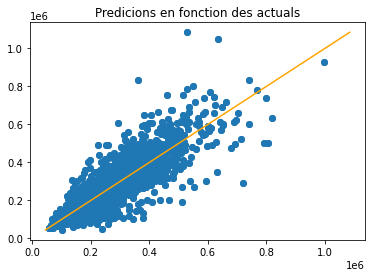

In [16]:
plt.scatter(res_clf_final.Predicted, res_clf_final.Actual)
plt.plot((res_clf_final.Actual.min(),res_clf_final.Actual.max()), (res_clf_final.Actual.min(),res_clf_final.Actual.max()), 'orange')
plt.title("Predicions en fonction des actuals");

# TEST

In [9]:
res_rf_final = pd.DataFrame(columns=['Actual','Predicted','Code departement'])

for i in df['Code departement'].unique():
    data_departement = df[df["Code departement"]==i]
    target = data_departement["Valeur fonciere"]
    data = data_departement.drop(["Valeur fonciere","Code departement"],axis = 1)
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=789)
    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train)
    X_test=scaler.transform(X_test)
    pca  = PCA(n_components = 0.9)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)
    regr = RandomForestRegressor(random_state=0,n_jobs=-1)
    regr.fit(X_train,y_train)
    y_pred = regr.predict(X_test)
    res_rf = pd.DataFrame(columns=['Actual','Predicted','Code departement'])
    res_rf["Actual"] = y_test
    res_rf["Predicted"] = y_pred
    res_rf['Code departement'] = i
    res_rf_final = res_rf_final.append(res_rf)
    print("RESULTATS pour le département : " , i)
    #print("Coefficient de détermination du modèle :", lr.score(X_train, y_train))
    print('Score de l ensemble de test', regr.score(X_test,y_test))
    #print("RMSE test : ", np.sqrt(mean_squared_error(y_test, y_pred)))
    print("MAE test : ", mean_absolute_error(y_test, y_pred))
    
print("RMSE FINAL RF test : ", np.sqrt(mean_squared_error(res_rf_final.Actual, res_rf_final.Predicted)))
print("MAE FINAL RF test : ", mean_absolute_error(res_rf_final.Actual, res_rf_final.Predicted))



<IPython.core.display.Javascript object>

RESULTATS pour le département :  75
Score de l ensemble de test 0.866892208021337
MAE test :  91691.18460639023


<IPython.core.display.Javascript object>

RESULTATS pour le département :  1
Score de l ensemble de test 0.7889051762456745
MAE test :  48702.11693024405


<IPython.core.display.Javascript object>

RESULTATS pour le département :  2
Score de l ensemble de test 0.5220344067907415
MAE test :  30873.65040576794


<IPython.core.display.Javascript object>

RESULTATS pour le département :  3
Score de l ensemble de test 0.4969081640886672
MAE test :  34970.41494392116


<IPython.core.display.Javascript object>

RESULTATS pour le département :  4
Score de l ensemble de test 0.5451070031443643
MAE test :  43483.15594098202


<IPython.core.display.Javascript object>

RESULTATS pour le département :  5
Score de l ensemble de test 0.6851463633614612
MAE test :  35696.28678619002


<IPython.core.display.Javascript object>

RESULTATS pour le département :  6
Score de l ensemble de test 0.6232734931494512
MAE test :  61119.844730661986


<IPython.core.display.Javascript object>

RESULTATS pour le département :  7
Score de l ensemble de test 0.5178610481338076
MAE test :  45035.80517790635


<IPython.core.display.Javascript object>

RESULTATS pour le département :  8
Score de l ensemble de test 0.5455604468266727
MAE test :  26634.45614280443


<IPython.core.display.Javascript object>

RESULTATS pour le département :  9
Score de l ensemble de test 0.5944090389196668
MAE test :  29188.70380658548


<IPython.core.display.Javascript object>

RESULTATS pour le département :  10
Score de l ensemble de test 0.5659084907542313
MAE test :  33525.147975682805


<IPython.core.display.Javascript object>

RESULTATS pour le département :  11
Score de l ensemble de test 0.7480833218107961
MAE test :  28116.593488983268


<IPython.core.display.Javascript object>

RESULTATS pour le département :  12
Score de l ensemble de test 0.8943213089116038
MAE test :  16382.948893211753


<IPython.core.display.Javascript object>

RESULTATS pour le département :  13
Score de l ensemble de test 0.7423889196359678
MAE test :  48301.64784282935


<IPython.core.display.Javascript object>

RESULTATS pour le département :  14
Score de l ensemble de test 0.702395038141167
MAE test :  48599.488859806006


<IPython.core.display.Javascript object>

RESULTATS pour le département :  15
Score de l ensemble de test 0.5445036770152433
MAE test :  27082.975935714287


<IPython.core.display.Javascript object>

RESULTATS pour le département :  16
Score de l ensemble de test 0.3771844174954656
MAE test :  36251.18275145896


<IPython.core.display.Javascript object>

RESULTATS pour le département :  17
Score de l ensemble de test 0.6339457785286517
MAE test :  56968.03615679676


<IPython.core.display.Javascript object>

RESULTATS pour le département :  18
Score de l ensemble de test 0.4007365576418931
MAE test :  34491.70890568272


<IPython.core.display.Javascript object>

RESULTATS pour le département :  19
Score de l ensemble de test 0.12947115498224515
MAE test :  36072.89726476617


<IPython.core.display.Javascript object>

RESULTATS pour le département :  21
Score de l ensemble de test 0.6861583051352911
MAE test :  39186.889026600344


<IPython.core.display.Javascript object>

RESULTATS pour le département :  22
Score de l ensemble de test 0.4968976095203337
MAE test :  44676.11665753439


<IPython.core.display.Javascript object>

RESULTATS pour le département :  23
Score de l ensemble de test 0.3806677740072306
MAE test :  36837.86968253968


<IPython.core.display.Javascript object>

RESULTATS pour le département :  24
Score de l ensemble de test 0.5488433654129127
MAE test :  42250.630915167545


<IPython.core.display.Javascript object>

RESULTATS pour le département :  25
Score de l ensemble de test 0.7062007665826742
MAE test :  35016.231800202884


<IPython.core.display.Javascript object>

RESULTATS pour le département :  26
Score de l ensemble de test 0.6129783859424728
MAE test :  39141.55802158154


<IPython.core.display.Javascript object>

RESULTATS pour le département :  27
Score de l ensemble de test 0.6710680420524883
MAE test :  26102.214210768107


<IPython.core.display.Javascript object>

RESULTATS pour le département :  28
Score de l ensemble de test 0.686320864779402
MAE test :  30328.50874442089


<IPython.core.display.Javascript object>

RESULTATS pour le département :  29
Score de l ensemble de test 0.6303641330855821
MAE test :  35691.56058546906


<IPython.core.display.Javascript object>

RESULTATS pour le département :  30
Score de l ensemble de test 0.697191574687816
MAE test :  37241.30917389825


<IPython.core.display.Javascript object>

RESULTATS pour le département :  31
Score de l ensemble de test 0.7184523643275762
MAE test :  41951.750222270035


<IPython.core.display.Javascript object>

RESULTATS pour le département :  32
Score de l ensemble de test 0.6190586810910728
MAE test :  37046.06583291016


<IPython.core.display.Javascript object>

RESULTATS pour le département :  33
Score de l ensemble de test 0.751593598518478
MAE test :  52503.88839108627


<IPython.core.display.Javascript object>

RESULTATS pour le département :  34
Score de l ensemble de test 0.7272296383468684
MAE test :  38779.84286304916


<IPython.core.display.Javascript object>

RESULTATS pour le département :  35
Score de l ensemble de test 0.8525183706830757
MAE test :  30027.726823182114


<IPython.core.display.Javascript object>

RESULTATS pour le département :  36
Score de l ensemble de test 0.2671813774485916
MAE test :  40728.3562425


<IPython.core.display.Javascript object>

RESULTATS pour le département :  37
Score de l ensemble de test 0.702500368849762
MAE test :  39563.55196215246


<IPython.core.display.Javascript object>

RESULTATS pour le département :  38
Score de l ensemble de test 0.6775675698695547
MAE test :  40955.48232253284


<IPython.core.display.Javascript object>

RESULTATS pour le département :  39
Score de l ensemble de test 0.8088046231949988
MAE test :  22050.137460119044


<IPython.core.display.Javascript object>

RESULTATS pour le département :  40
Score de l ensemble de test 0.7491447959579123
MAE test :  36418.92505764307


<IPython.core.display.Javascript object>

RESULTATS pour le département :  41
Score de l ensemble de test 0.47739569895275547
MAE test :  34039.45021540505


<IPython.core.display.Javascript object>

RESULTATS pour le département :  42
Score de l ensemble de test 0.5833788494231301
MAE test :  36198.82962812752


<IPython.core.display.Javascript object>

RESULTATS pour le département :  43
Score de l ensemble de test 0.44974010381969154
MAE test :  37834.449206757374


<IPython.core.display.Javascript object>

RESULTATS pour le département :  44
Score de l ensemble de test 0.7253838316947958
MAE test :  49779.894165034275


<IPython.core.display.Javascript object>

RESULTATS pour le département :  45
Score de l ensemble de test 0.6299966583072596
MAE test :  33924.079363829485


<IPython.core.display.Javascript object>

RESULTATS pour le département :  46
Score de l ensemble de test 0.6631699874594301
MAE test :  33828.5706904762


<IPython.core.display.Javascript object>

RESULTATS pour le département :  47
Score de l ensemble de test 0.5257121140701976
MAE test :  35907.5908852595


<IPython.core.display.Javascript object>

RESULTATS pour le département :  48
Score de l ensemble de test 0.1937710143091823
MAE test :  42414.605978766594


<IPython.core.display.Javascript object>

RESULTATS pour le département :  49
Score de l ensemble de test 0.6577940329022564
MAE test :  38992.61773648102


<IPython.core.display.Javascript object>

RESULTATS pour le département :  50
Score de l ensemble de test 0.5237932440433863
MAE test :  41585.18154901298


<IPython.core.display.Javascript object>

RESULTATS pour le département :  51
Score de l ensemble de test 0.6556020312876181
MAE test :  40464.916298054864


<IPython.core.display.Javascript object>

RESULTATS pour le département :  52
Score de l ensemble de test 0.41865481480474753
MAE test :  25597.034820092915


<IPython.core.display.Javascript object>

RESULTATS pour le département :  53
Score de l ensemble de test 0.5504885165072292
MAE test :  31426.557009049775


<IPython.core.display.Javascript object>

RESULTATS pour le département :  54
Score de l ensemble de test 0.634521898237008
MAE test :  34193.88180739161


<IPython.core.display.Javascript object>

RESULTATS pour le département :  55
Score de l ensemble de test 0.5533692861802444
MAE test :  22745.948823529412


<IPython.core.display.Javascript object>

RESULTATS pour le département :  56
Score de l ensemble de test 0.661296452911257
MAE test :  50147.16711800571


<IPython.core.display.Javascript object>

RESULTATS pour le département :  58
Score de l ensemble de test 0.583547189065124
MAE test :  25971.983711111116


<IPython.core.display.Javascript object>

RESULTATS pour le département :  59
Score de l ensemble de test 0.6831514113677457
MAE test :  41471.366228801635


<IPython.core.display.Javascript object>

RESULTATS pour le département :  60
Score de l ensemble de test 0.682827691260323
MAE test :  37701.97720302548


<IPython.core.display.Javascript object>

RESULTATS pour le département :  61
Score de l ensemble de test 0.4130863214392019
MAE test :  36724.62666666666


<IPython.core.display.Javascript object>

RESULTATS pour le département :  62
Score de l ensemble de test 0.6435697921863713
MAE test :  35776.46579117952


<IPython.core.display.Javascript object>

RESULTATS pour le département :  63
Score de l ensemble de test 0.5621996341674547
MAE test :  37409.35326700272


<IPython.core.display.Javascript object>

RESULTATS pour le département :  64
Score de l ensemble de test 0.6509486850173536
MAE test :  48396.2034935595


<IPython.core.display.Javascript object>

RESULTATS pour le département :  65
Score de l ensemble de test 0.5145478339785079
MAE test :  30962.053389568693


<IPython.core.display.Javascript object>

RESULTATS pour le département :  66
Score de l ensemble de test 0.6064144987284902
MAE test :  37156.42817484862


<IPython.core.display.Javascript object>

RESULTATS pour le département :  69
Score de l ensemble de test 0.7038532870212288
MAE test :  59289.1822306509


<IPython.core.display.Javascript object>

RESULTATS pour le département :  70
Score de l ensemble de test 0.4545108832586039
MAE test :  28482.922511057695


<IPython.core.display.Javascript object>

RESULTATS pour le département :  71
Score de l ensemble de test 0.45809698776060204
MAE test :  36045.76931859649


<IPython.core.display.Javascript object>

RESULTATS pour le département :  72
Score de l ensemble de test 0.6788259915530219
MAE test :  29452.12142450132


<IPython.core.display.Javascript object>

RESULTATS pour le département :  73
Score de l ensemble de test 0.6561285005623136
MAE test :  45891.43771902594


<IPython.core.display.Javascript object>

RESULTATS pour le département :  74
Score de l ensemble de test 0.7215723383094953
MAE test :  59056.57831302389


<IPython.core.display.Javascript object>

RESULTATS pour le département :  76
Score de l ensemble de test 0.696456279722087
MAE test :  34605.40442870257


<IPython.core.display.Javascript object>

RESULTATS pour le département :  77
Score de l ensemble de test 0.730161380040325
MAE test :  37677.992975255474


<IPython.core.display.Javascript object>

RESULTATS pour le département :  78
Score de l ensemble de test 0.7888076353237617
MAE test :  58379.83595230741


<IPython.core.display.Javascript object>

RESULTATS pour le département :  79
Score de l ensemble de test 0.518927139933415
MAE test :  32921.46606398186


<IPython.core.display.Javascript object>

RESULTATS pour le département :  80
Score de l ensemble de test 0.6067588041024765
MAE test :  34818.71197181149


<IPython.core.display.Javascript object>

RESULTATS pour le département :  81
Score de l ensemble de test 0.46973354902576425
MAE test :  35598.46258145363


<IPython.core.display.Javascript object>

RESULTATS pour le département :  82
Score de l ensemble de test 0.5754976545765145
MAE test :  33613.99478418097


<IPython.core.display.Javascript object>

RESULTATS pour le département :  83
Score de l ensemble de test 0.6686812117719096
MAE test :  57508.69403164568


<IPython.core.display.Javascript object>

RESULTATS pour le département :  84
Score de l ensemble de test 0.5930265819446663
MAE test :  46681.689086436425


<IPython.core.display.Javascript object>

RESULTATS pour le département :  85
Score de l ensemble de test 0.6244380488519337
MAE test :  42129.85806521069


<IPython.core.display.Javascript object>

RESULTATS pour le département :  86
Score de l ensemble de test 0.6176950774816686
MAE test :  28877.109169702755


<IPython.core.display.Javascript object>

RESULTATS pour le département :  87
Score de l ensemble de test 0.6246277416763459
MAE test :  31750.936385536297


<IPython.core.display.Javascript object>

RESULTATS pour le département :  88
Score de l ensemble de test 0.3972561622141253
MAE test :  33321.742793842575


<IPython.core.display.Javascript object>

RESULTATS pour le département :  89
Score de l ensemble de test 0.5258574674325643
MAE test :  30389.34546922311


<IPython.core.display.Javascript object>

RESULTATS pour le département :  90
Score de l ensemble de test 0.5993756571727444
MAE test :  32879.691005354296


<IPython.core.display.Javascript object>

RESULTATS pour le département :  91
Score de l ensemble de test 0.7793266757842305
MAE test :  37677.88334579211


<IPython.core.display.Javascript object>

RESULTATS pour le département :  92
Score de l ensemble de test 0.7699577619801972
MAE test :  75909.27804335514


<IPython.core.display.Javascript object>

RESULTATS pour le département :  93
Score de l ensemble de test 0.7041439225192445
MAE test :  48553.55180089059


<IPython.core.display.Javascript object>

RESULTATS pour le département :  94
Score de l ensemble de test 0.79246555640639
MAE test :  59812.22236679978


<IPython.core.display.Javascript object>

RESULTATS pour le département :  95
Score de l ensemble de test 0.7385554743878153
MAE test :  42735.314954065005
RMSE FINAL RF test :  73887.1959479062
MAE FINAL RF test :  45669.51340643249
